#**California Housing Price Prediction**




##Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##Download the Data


In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

##Create a Test Set


In [7]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [8]:

from sklearn.model_selection import StratifiedShuffleSplit

# Create a StratifiedShuffleSplit instance
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data based on 'income_cat'
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

#Prepare the Data for Machine Learning Algorithms


In [10]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training settrain_set.copy()
housing_labels = strat_train_set["median_house_value"].copy()

##Data Cleaning

In [11]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [13]:
housing_num = housing.select_dtypes(include=[np.number])

In [14]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [15]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580
...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,433.0,3207.0,1012.0,4.0767
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
9149,-118.50,34.46,17.0,10267.0,433.0,4956.0,1483.0,5.5061
16757,-122.48,37.70,33.0,4492.0,433.0,3477.0,1537.0,3.0546


##Handling Text and Categorical Attributes


In [16]:
housing_cat = housing.select_dtypes(exclude=[np.number])

In [17]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [18]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [19]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [20]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

##Custom Transformers

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

##Transformation Pipelines


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [23]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        self.kmeans = None

    def fit(self, X, y=None, sample_weight=None):
        # Initialize and fit the KMeans clustering
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        # Compute the RBF kernel similarity between X and the cluster centers
        cluster_centers = self.kmeans.cluster_centers_
        similarities = rbf_kernel(X, cluster_centers, gamma=self.gamma)
        return similarities

    def get_feature_names_out(self, names=None):
        return [f"cluster_similarity_{i}" for i in range(self.n_clusters)]

##Full pipeline

In [25]:
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil=ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False))
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)


#Select and Train a Model


##Training and Evaluating on the Training Set


In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
def get_rmse(housing_labels, predicted_data):
    mse = mean_squared_error(housing_labels, predicted_data)
    rmse = np.sqrt(mse)
    return rmse
def get_mae(housing_labels, predicted_data):
    mae=mean_absolute_error(housing_labels, predicted_data)
    return mae

###LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = get_rmse(housing_labels, housing_predictions)
lin_rmse

68627.87390018745

In [ ]:
lin_mae =get_mae(housing_labels, housing_predictions)
lin_mae

49438.66860915802

###DecisionTreeRegressor

In [ ]:

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = get_rmse(housing_labels, housing_predictions)
tree_rmse

0.0

In [ ]:
tree_mea =get_mae(housing_labels, housing_predictions)
tree_mea

0.0

###RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg= RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
rf_rmse = get_rmse(housing_labels, housing_predictions)
rf_rmse

18650.698705770003

In [ ]:
rf_mea =get_mae(housing_labels, housing_predictions)
rf_mea

12061.519983648257

###Support Vector Machine Regressor




In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_mae =get_mae(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(svm_rmse)
print(svm_mae)

111095.06635291968
81843.53472284484


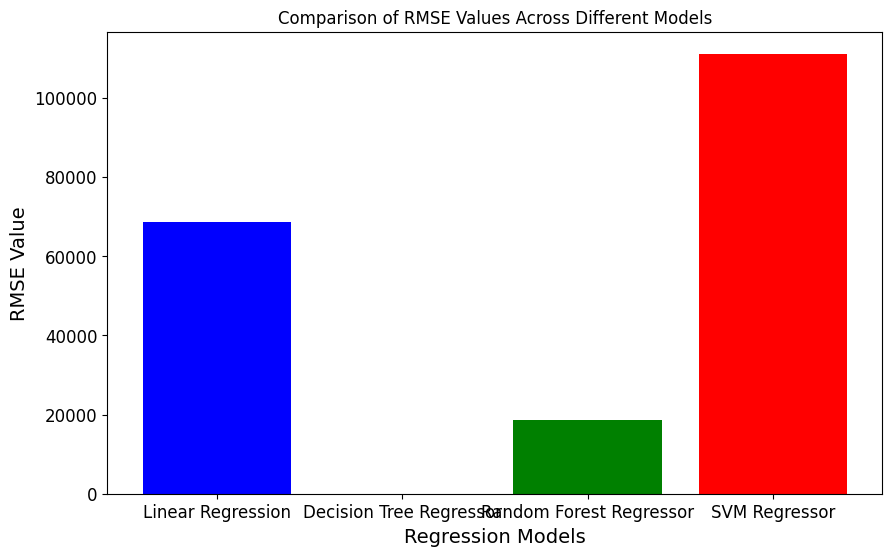

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'SVM Regressor']
rmse_values = [68627, 0, 18650, 111095]
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=colors)

plt.ylabel('RMSE Value')
plt.xlabel('Regression Models')
plt.title('Comparison of RMSE Values Across Different Models')
plt.show()

###Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

def cross_validation(reg_model, housing_prepared, housing_labels):
    scores = cross_val_score(
      reg_model, housing_prepared,
      housing_labels,
      scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print("Scores:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("StandardDeviation:", rmse_scores.std())

print("Decision Tree Regression Model Cross Validation")
cross_validation(tree_reg, housing_prepared, housing_labels)
print("Linear Regression Model Cross Validation")
cross_validation(lin_reg, housing_prepared, housing_labels)
print("Random Forest Regression Model Cross Validation")
cross_validation(forest_reg, housing_prepared, housing_labels)
print("Support Vector Regression Model Cross Validation")
cross_validation(svm_reg, housing_prepared, housing_labels)

Decision Tree Regression Model Cross Validation
Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
StandardDeviation: 2914.035468468928
Linear Regression Model Cross Validation
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
StandardDeviation: 2880.3282098180694
Random Forest Regression Model Cross Validation
Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
StandardDeviation: 2203.3381412764606
Support Vector Regression Model Cross Validation
Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 11316

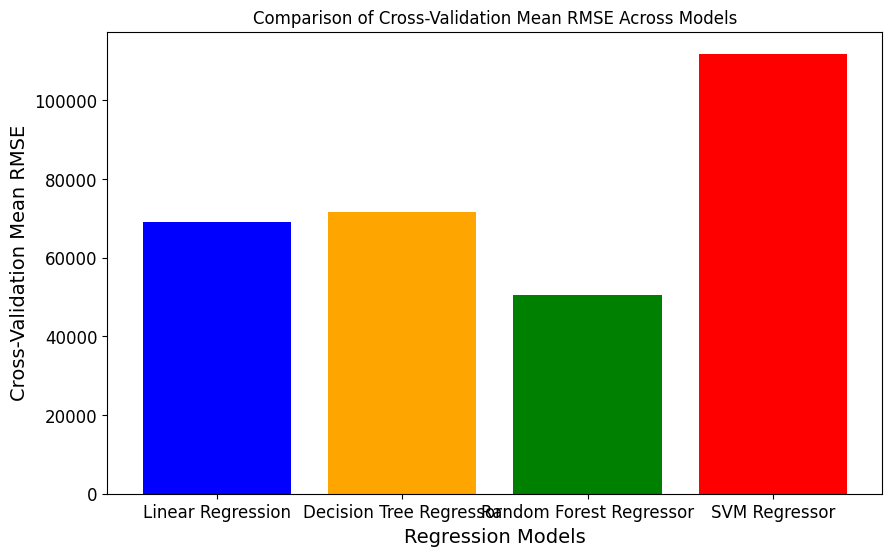

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'SVM Regressor']
cv_mean_values = [69104, 71629, 50435, 111814]
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))
plt.bar(models, cv_mean_values, color=colors)

plt.ylabel('Cross-Validation Mean RMSE')
plt.xlabel('Regression Models')
plt.title('Comparison of Cross-Validation Mean RMSE Across Models')

plt.show()

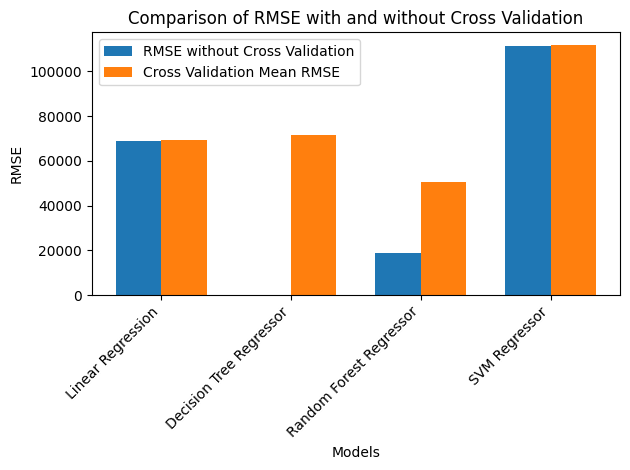

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'SVM Regressor']
rmse_without_cross = [68627, 0, 18650, 111095]
cross_validation_rmse = [69104, 71629, 50435, 111814]


x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_without_cross, width, label='RMSE without Cross Validation')
rects2 = ax.bar(x + width/2, cross_validation_rmse, width, label='Cross Validation Mean RMSE')


ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE with and without Cross Validation')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


plt.xticks(rotation=45, ha="right")
plt.tight_layout()


plt.show()


### Grid Search

####Linear Regression

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Define the Linear Regression model
linear_model = LinearRegression()

# Define the hyperparameter grid for Grid Search
param_grid = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
}

# Create the GridSearchCV object
lre_search = GridSearchCV(linear_model, param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error', error_score='raise')

# Fit the model to the training data
lre_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score='raise', estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None]},
             scoring='neg_mean_squared_error')

In [28]:
# Best model from Grid Search
best_model = lre_search.best_estimator_
print(f"Best Parameters (Grid Search): {lre_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse = lre_search.best_score_
rmse = np.sqrt(-negative_mse)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse}")

Best Parameters (Grid Search): {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}
Best Score (RMSE): 69077.320490394


#### Decision Tree Regression

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
dt_search = GridSearchCV(decision_tree_model, param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')

# Fit the model to the training data
dt_search.fit(housing_prepared, housing_labels)



GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [30]:
# Best model from Grid Search
best_model = dt_search.best_estimator_

# Output the best parameters found
print(f"Best Parameters (Grid Search): {dt_search.best_params_}")

negative_mse = dt_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse
print(f"Best Score: {rmse}")


Best Parameters (Grid Search): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Score: 60696.52664554647


####Random Forest Regression

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
rf_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
rf_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [37]:
# Output the best parameters found
print(f"Best Parameters (Grid Search): {rf_search.best_params_}")

# Accuracy of the model after using best parameters
negative_mse = rf_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse
print(f"Best Score: {rmse}")


Best Parameters (Grid Search): {'max_features': 8, 'n_estimators': 30}
Best Score: 49898.98913455217


####SVR

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
svr_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
svr_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  11.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.2s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.0s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.1s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.2s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.0s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   8.3s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.6s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.0s
[CV] END .............................C=100.0, kernel=linear; total time=   9.6s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
print(f"Best Parameters: {svr_search.best_params_}")
print(f"Best Score (Negative MSE): {svr_search.best_score_}")
negative_mse = svr_search.best_score_
rmse = np.sqrt(-negative_mse)
print(f"Best Score (RMSE): {rmse}")

Best Parameters: {'C': 30000.0, 'kernel': 'linear'}
Best Score (Negative MSE): -4940208719.617756
Best Score (RMSE): 70286.61835383571


###Randomized Search

####Linear Regression

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np

# Define the Linear Regression model
linear_model = LinearRegression()

# Define the hyperparameter grid for Randomized Search
param_distributions = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [1, 5, 10, 15, None],
}

# Create the RandomizedSearchCV object
lre_random_search = RandomizedSearchCV(linear_model, param_distributions, n_iter=20, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, error_score='raise')

# Fit the model to the training data
lre_random_search.fit(housing_prepared, housing_labels)

# Best model from Randomized Search
best_model = lre_random_search.best_estimator_

# Output the best parameters found
print(f"Best Parameters (Randomized Search): {lre_random_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse = lre_random_search.best_score_
rmse = np.sqrt(-negative_mse)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse}")


Best Parameters (Randomized Search): {'n_jobs': 1, 'fit_intercept': True, 'copy_X': True}
Best Score (RMSE): 69077.320490394


####Decision Tree Regression

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint  # Import randint for sampling from integer distributions

# Define the Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor()

# Define the hyperparameter distribution for Randomized Search
param_dist = {
    'max_depth': [None, 5, 10, 15, 20],  # Depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node (randomized)
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node (randomized)
}

# Create the RandomizedSearchCV object
dt_random_search = RandomizedSearchCV(decision_tree_model, param_dist, n_iter=50, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

# Fit the model to the training data
dt_random_search.fit(housing_prepared, housing_labels)

# Best model from Randomized Search
best_model_dt = dt_random_search.best_estimator_

# Output the best parameters found
print(f"Best Parameters (Randomized Search): {dt_random_search.best_params_}")

# Calculate RMSE from the negative MSE
negative_mse_dt = dt_random_search.best_score_
rmse_dt = np.sqrt(-negative_mse_dt)  # Convert negative MSE to positive before taking the square root

print(f"Best Score (RMSE): {rmse_dt}")


Best Parameters (Randomized Search): {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5}
Best Score (RMSE): 60041.56913568028


####Random Forest Regression

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import numpy as np



# Define parameter distributions for Randomized Search
param_distribs = {
    'n_estimators': randint(low=10, high=200),  # Reduced range
    'max_features': randint(low=1, high=housing_prepared.shape[1]),  # Ensure max_features is within valid range
}

# Create an instance of Random Forest Regressor
forest_reg = RandomForestRegressor(random_state=42)

# Create the RandomizedSearchCV object with simplified settings
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=2)

# Fit the model to the training data, with error handling

rnd_search.fit(housing_prepared, housing_labels)
print(f"Best Parameters: {rnd_search.best_params_}")
print(f"Best Score (Negative MSE): {rnd_search.best_score_}")

    # Calculate RMSE from the negative MSE
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(f"Best Score (RMSE): {rmse}")

    # Print the best estimator
print(f"Best Estimator: {rnd_search.best_estimator_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...................max_features=7, n_estimators=189; total time=  18.4s
[CV] END ...................max_features=7, n_estimators=189; total time=  19.1s
[CV] END ...................max_features=7, n_estimators=189; total time=  18.0s
[CV] END ...................max_features=7, n_estimators=189; total time=  18.4s
[CV] END ...................max_features=7, n_estimators=189; total time=  19.2s
[CV] END ...................max_features=13, n_estimators=24; total time=   3.8s
[CV] END ...................max_features=13, n_estimators=24; total time=   4.1s
[CV] END ...................max_features=13, n_estimators=24; total time=   4.4s
[CV] END ...................max_features=13, n_estimators=24; total time=   3.8s
[CV] END ...................max_features=13, n_estimators=24; total time=   3.8s
[CV] END ...................max_features=11, n_estimators=81; total time=  12.5s
[CV] END ...................max_features=11, n_

In [50]:
 # Calculate RMSE from the negative MSE
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(f"Best Score (RMSE): {rmse}")

    # Print the best estimator
print(f"Best Estimator: {rnd_search.best_estimator_}")


Best Score (RMSE): 49095.15244849487
Best Estimator: RandomForestRegressor(max_features=7, n_estimators=189, random_state=42)


####SVR

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
svr_random_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
svr_random_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.4s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.1s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=  10.1s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.9s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.5s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  18.3s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  17.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  17.4s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  17.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  18.2s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x794e2c246440>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x794e2c253ee0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [49]:
print(f"Best Parameters: {svr_random_search.best_params_}")
print(f"Best Score (Negative MSE): {svr_random_search.best_score_}")

# Calculate RMSE from the negative MSE
negative_mse = svr_random_search.best_score_
rmse = np.sqrt(-negative_mse)  # Convert negative MSE to positive before taking the square root
print(f"Best Score (RMSE): {rmse}")

Best Parameters: {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}
Best Score (Negative MSE): -2997747568.2458334
Best Score (RMSE): 54751.69009488048


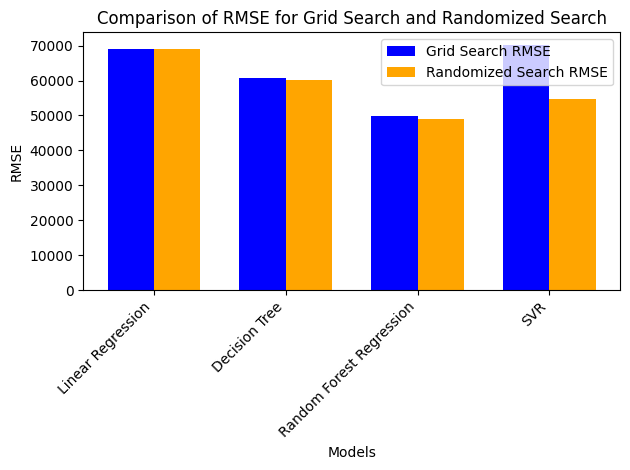

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table provided
models = ['Linear Regression', 'Decision Tree', 'Random Forest Regression', 'SVR']
grid_search_rmse = [69077, 60696, 49898, 70287]
random_search_rmse = [69077, 60041, 49095, 54751]

# Creating bar chart
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, grid_search_rmse, width, label='Grid Search RMSE', color='blue')
bars2 = ax.bar(x + width/2, random_search_rmse, width, label='Randomized Search RMSE', color='orange')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE for Grid Search and Randomized Search')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


## Analyze the Best Models and Their Errors

In [45]:
final_model= rnd_search.best_estimator_
feature_importances = final_model.feature_importances_
feature_importances

array([7.18924077e-02, 6.36612638e-02, 4.28816744e-02, 1.64319162e-02,
       1.56513705e-02, 1.63878924e-02, 1.53165050e-02, 3.45913481e-01,
       5.96592932e-02, 1.10712424e-01, 6.86225497e-02, 8.66128084e-03,
       1.57817601e-01, 6.93315602e-05, 2.74666171e-03, 3.57434657e-03])

In [46]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3459134806433566, 'median_income'),
 (0.15781760137869993, 'INLAND'),
 (0.1107124243400684, 'pop_per_hhold'),
 (0.07189240765212901, 'longitude'),
 (0.06862254971910188, 'bedrooms_per_room'),
 (0.06366126379984527, 'latitude'),
 (0.059659293200034276, 'rooms_per_hhold'),
 (0.04288167437561998, 'housing_median_age'),
 (0.0164319162277109, 'total_rooms'),
 (0.016387892441324086, 'population'),
 (0.015651370521031244, 'total_bedrooms'),
 (0.01531650501223007, 'households'),
 (0.008661280843887361, '<1H OCEAN'),
 (0.0035743465730065913, 'NEAR OCEAN'),
 (0.0027466617117632773, 'NEAR BAY'),
 (6.933156019109008e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [47]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46971.31591732536

In [48]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44992.81843871, 48869.77928078])